In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib as mpl
from tqdm import tqdm,trange
import sys
sys.setrecursionlimit(10000)

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

<img src="attachment:image.png" width="250"> 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

<img src="attachment:image.png" width="250"> 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [3]:
def create_initial_config(N):
    """
    Create the starting initial configuration.
    
    All elements are {-1, 1} with 50% prob.
    The lattice is a square of size N.
    
    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    config = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            a=np.random.uniform(0,1)
            if a < 0.5:
                config[i][j]=+1
            else:
                config[i][j]=-1
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [4]:
config = create_initial_config(N=100)

To plot our system we can use `plt.imshow()`, as follows:

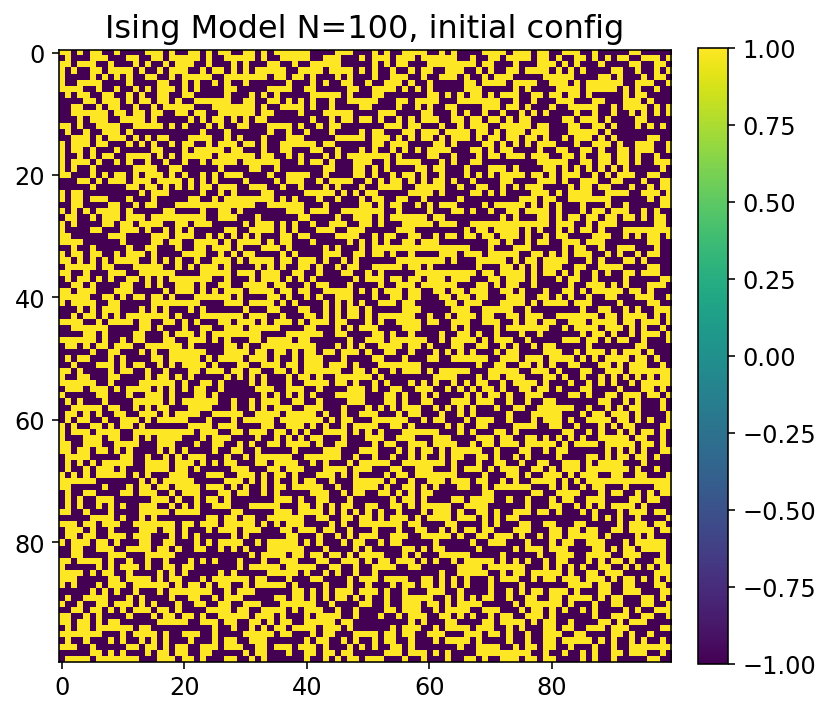

In [5]:
plt.figure(figsize=(6,6))
plt.title("Ising Model N=100, initial config")
plt.imshow(config)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

Nel momento in cui decidere di cambiare uno spin $s_0$ dalla sua configurazione alla nuova configurazione $s_1$, la variazione di energia $\Delta E$ è data esclusivamente dall'interazione di questo spin con i suoi spiin vicini che chiamo: $s_{\leftarrow}$, $s_{\rightarrow}$, $s_{\downarrow}$ e $s_{\uparrow}$.

Pertanto l'energia iniziale $E_0$ relativa allo spin non ancora flippato, e l'energia $E_1$ data dalal configurazione con lo spin flippato saranno date da:

- $E_0= - s_o \cdot [s_{\leftarrow} + s_{\rightarrow} + s_{\downarrow} + s_{\uparrow}]$
- $E_1= - s_1 \cdot [s_{\leftarrow} + s_{\rightarrow} + s_{\downarrow} + s_{\uparrow}]$

Pertanto ottengo che la variazione nell'energia $\Delta E$ sarà data da:

$$
\Delta E=E_1-E_0 = -(s_1-s_0) \cdot [s_{\leftarrow} + s_{\rightarrow} + s_{\downarrow} + s_{\uparrow}] = 2s_0 \cdot [s_{\leftarrow} + s_{\rightarrow} + s_{\downarrow} + s_{\uparrow}]
$$

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [6]:
def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape
    assert N==M, "Config is not square"
    
    # choose random site
    i = np.random.randint(1,N)
    j = np.random.randint(1,N)
    s =  config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 2*s*(config[i%N][(j+1)%N] + config[i%N][(j-1)%N] + config[(i+1)%N][j%N] + config[(i-1)%N][j%N])
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the sping
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        if np.random.uniform(0,1) < (np.exp(-DeltaE/T)):
            # flip the sping
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

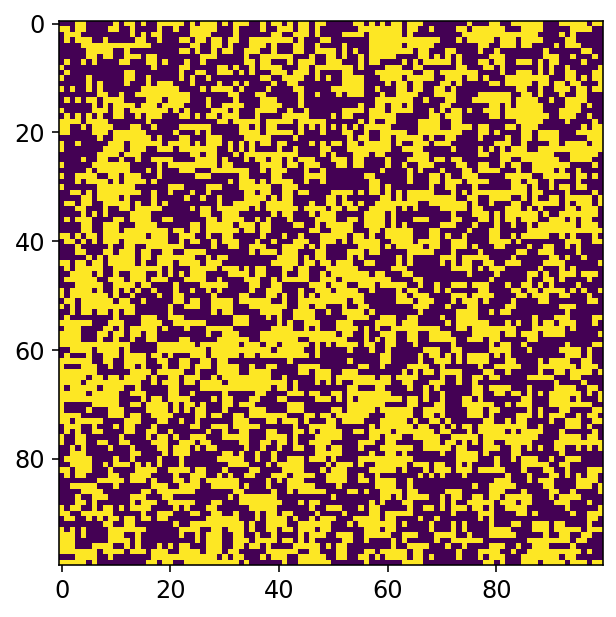

In [7]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=5)
    #DeltaE = metropolis_single_update(config, t)
    # replot every 1000 MC updates
    if t%500==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [8]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i%N, j%N, (i+1)%N, j%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i%N, j%N, i%N, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1][j1]*config[i2][j2]
    
    return E

In [9]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    
    config = create_initial_config(N)
    E = get_energy(config)
    Es = np.array(E)
    
    for t in range(n_updates):
        DeltaE = metropolis_single_update(config, T)
        E = E + DeltaE
        #if t%1000==0:
        Es=np.append(Es,E)
    
    return Es

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [10]:
Ts=[1, T_c, 10, 100]
res=[]

for T in tqdm(Ts):
    energy_evolution = get_energy_evolution(20, T, 100000)
    res.append(energy_evolution)

100%|█████████████████████████████████████████████| 4/4 [00:12<00:00,  3.08s/it]


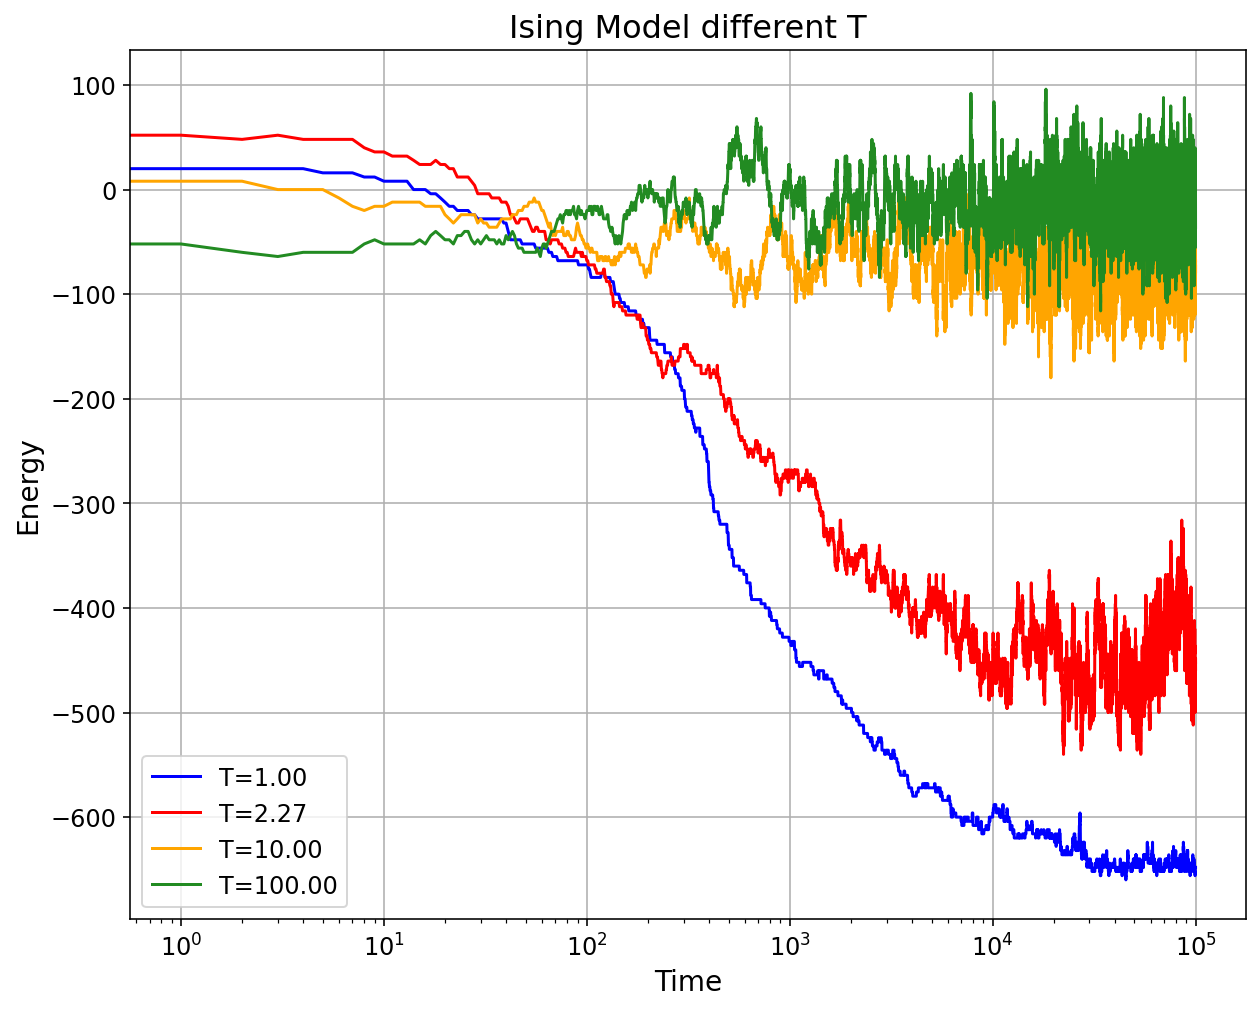

In [11]:
fig, axs = plt.subplots(1,1, figsize=(10, 8))  
color=['blue', 'red', 'orange', 'forestgreen']


for i in range(4):

    axs.semilogx(res[i], c=color[i], label=("T={:.2f}".format(Ts[i])))
axs.set_title("Ising Model different T")
axs.set_xlabel("Time")
axs.set_ylabel("Energy")
axs.legend()
axs.grid()


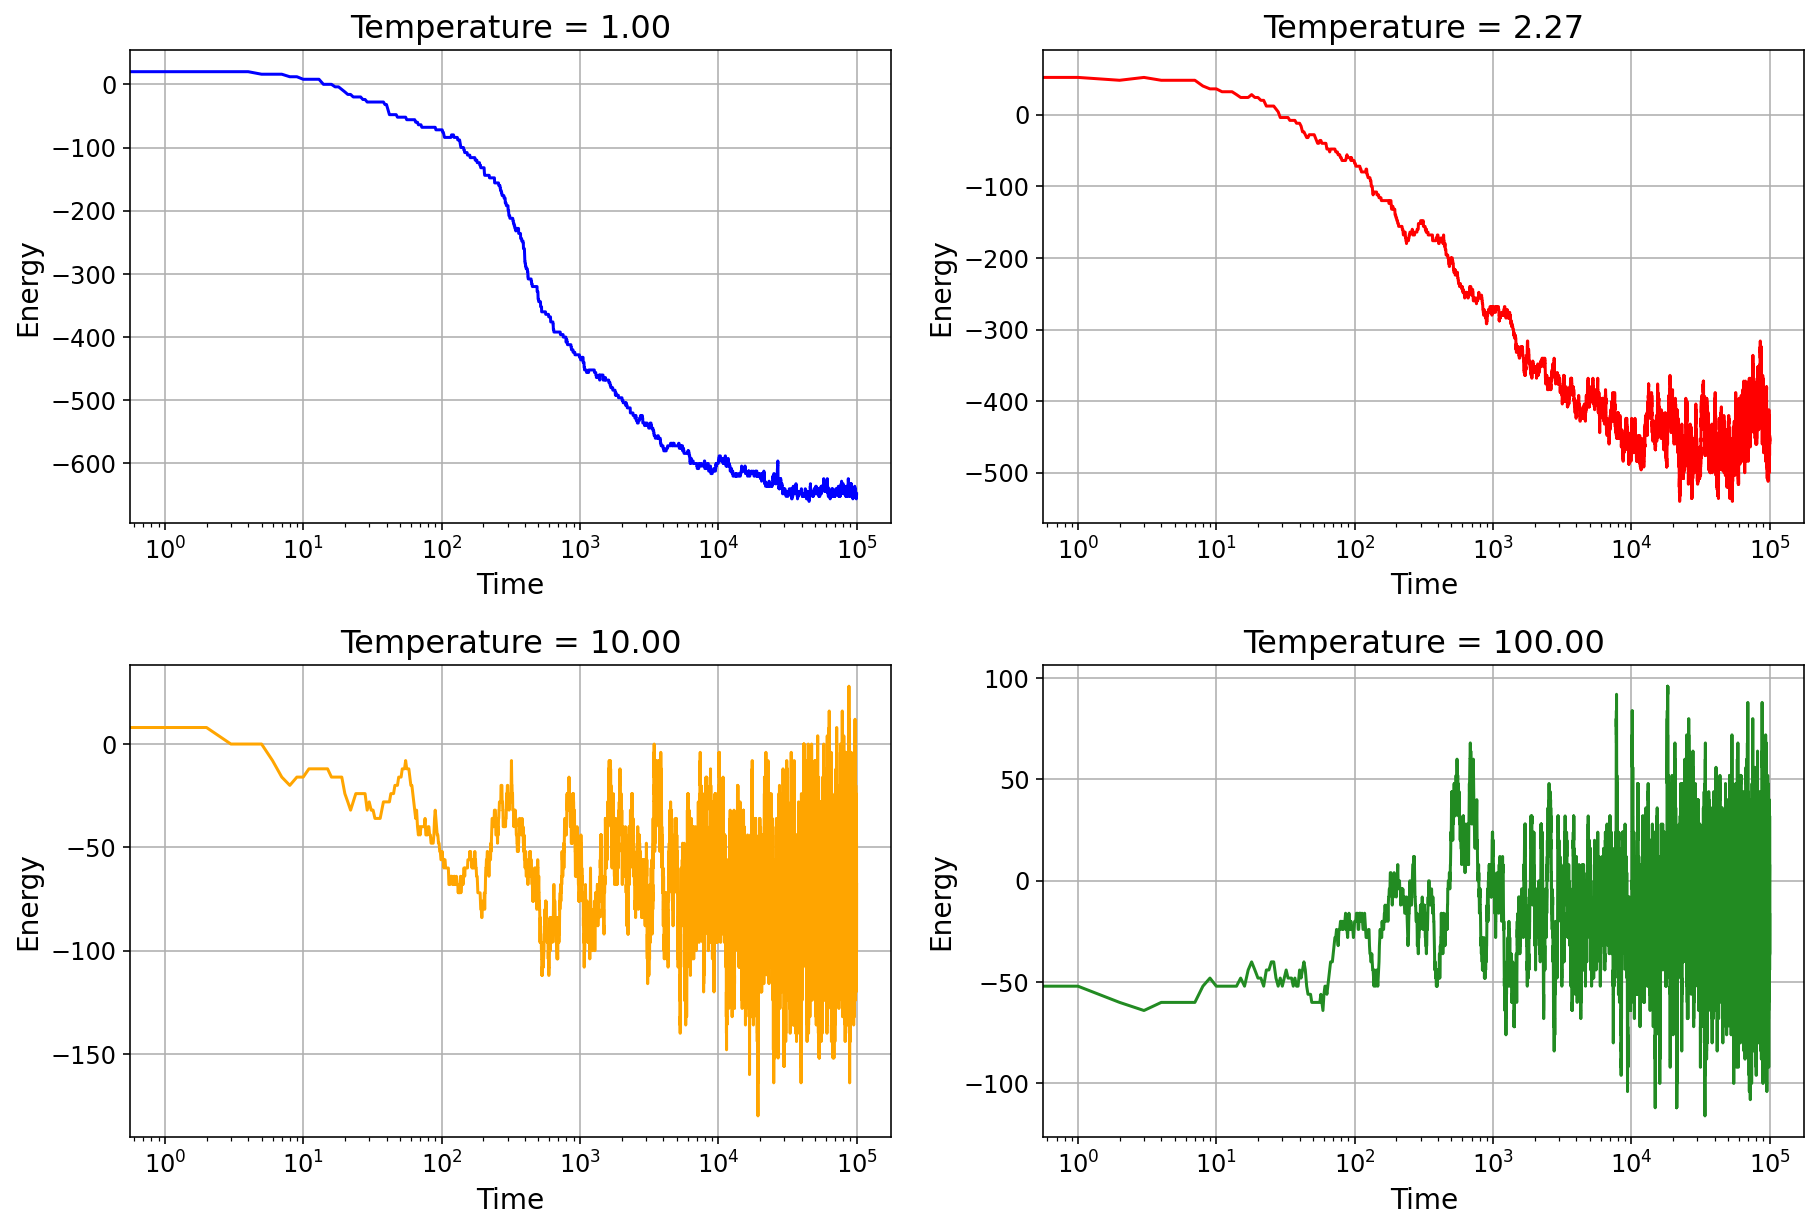

In [12]:
import pylab as pl
fig, axs = plt.subplots(2,2, figsize=(15, 10))
pl.subplots_adjust(hspace=0.3)
color=['blue', 'red', 'orange', 'forestgreen']
#, 'darkcyan','magenta'
axs = axs.ravel()

for i in range(4):
    axs[i].semilogx(res[i], c=color[i])
    axs[i].set_title("Temperature = {:.2f}".format(Ts[i]))
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Energy")
    axs[i].grid()

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

Studiando l'andamento dell'energia in funzione del tempo della simulazione posso distinguere due periodi differenti:
1. Il primo periodo è il periodo di equilibrazione. Inizialmente il sistema si trova in una conformazione casuale e quindi impiega un certo periodo di tempo per arrivare all'equilibrio, per termalizzarsi. Infatti, proprio per il fatto che la conformazione iniziale è random le prime conformazioni generate non sono conformazioni estratte con la probabilità di Boltzmann: l'energia avrà una forte variazione in funzione del tempo proprio come è possibile osservare dai grafici riportati. Col passare del tempo il sistema si termalizza cominciando ad estrarre le diverse conformazioni proprio con la distribuzione di equilibrio di Maxwell-Boltzmann. Nelle simulazioni a $T=1$ e a $T=T_c$, questo periodo di equilibrazione si aggira intorno ai $10^3 \sim 10^4$ steps. A temperature più alte invece l'equilibrazione è più rapida (come potevo aspettarmi) perchè con temperatura maggiore ho meno correlazione tra gli spins adiacenti e quindi con minore correlazione riesco a raggiungere la probabilità di equilibrio più in fretta: il tempo di equilibrazione si aggira attorno ai $10^2$ steps.
2. Dopo aver raggiunto l'equilibrio inizia il secondo periodo che è quello di fluttuazione statistica del sistema attorno all'equilibrio. Questo significa che le conformazioni iniziano ad essere correttamente estratte con la probabilità di Boltzmann, e la variazione dell'energia non subisce più forti variazioni, ma oscillerà attorno a un valor medio fisso. Questo è effettivamente quello che si può osservare dai grafici riportati.

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [13]:
import sys
sys.path.append("../code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [14]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [15]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

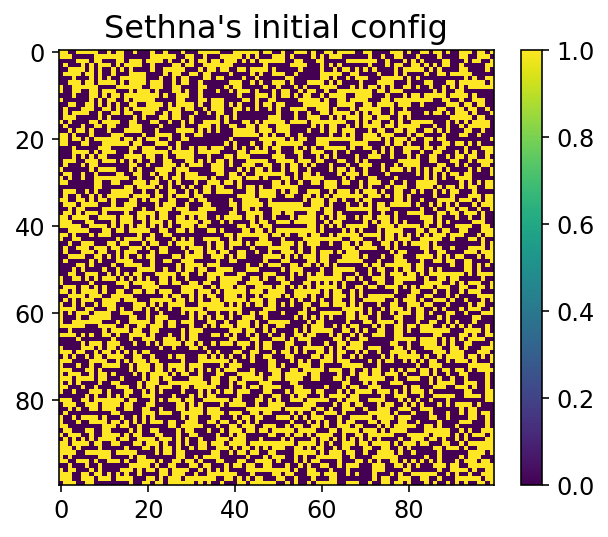

In [16]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

plt.title("Sethna's initial config")
plt.imshow(ising.lattice)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [17]:
ising.SweepMetropolis(nTimes=100)

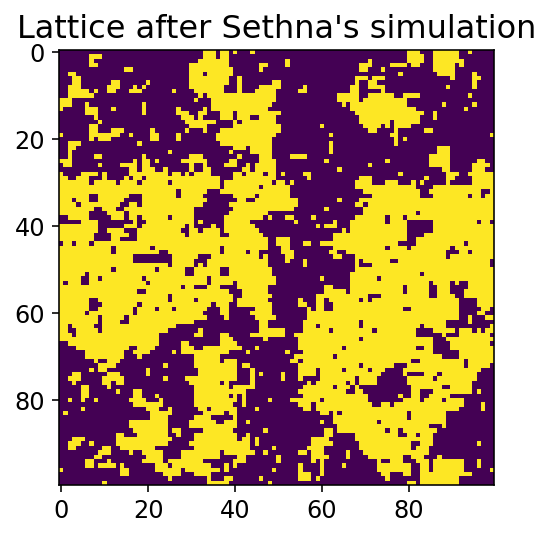

In [18]:
plt.title("Lattice after Sethna's simulation")
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [19]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

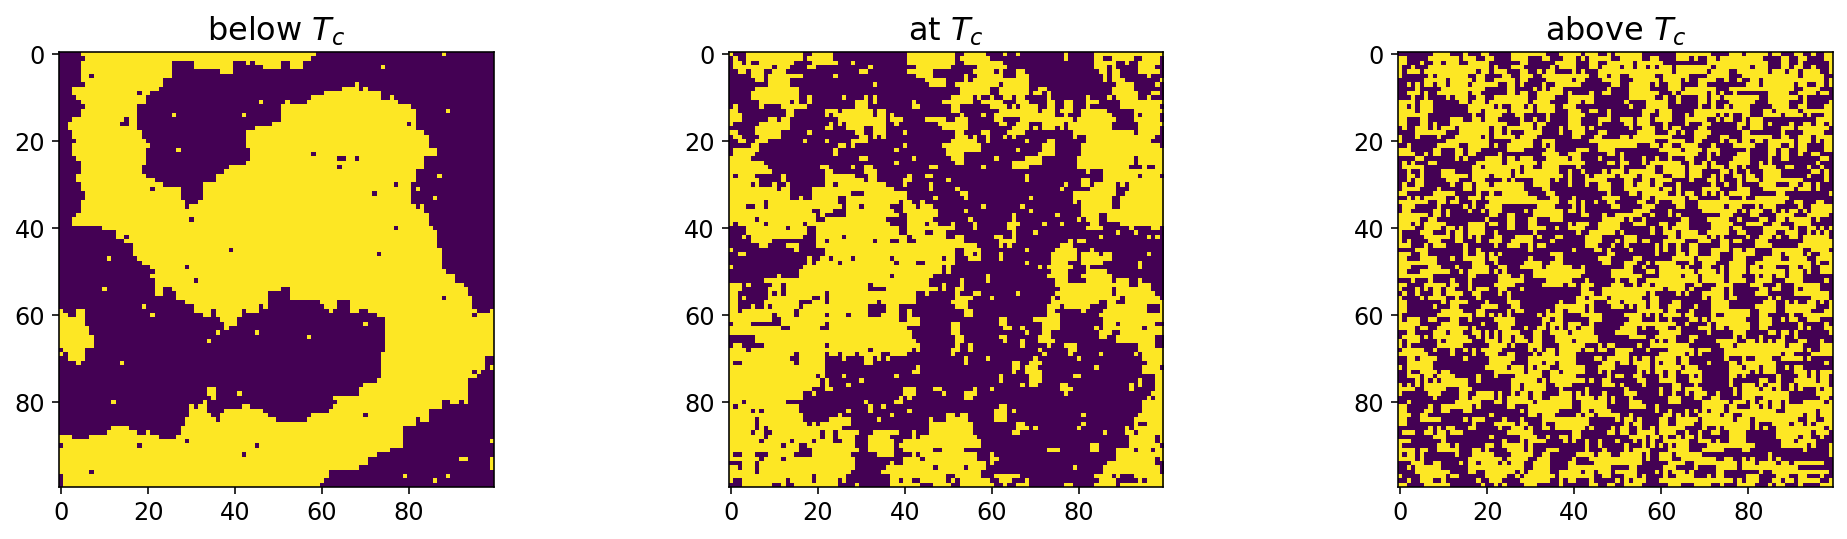

In [20]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [21]:
%%timeit
# My Ising implementation running for some number of updates
config = create_initial_config(N=100)

for t in range(50*100*100):
    metropolis_single_update(config, T=T_c)

5 s ± 328 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
ising = IsingModel(N=100)
ising.SweepMetropolis(nTimes=50)

1.72 s ± 88.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


L'implementazione di Sethna's è quasi tre volte più veloce dell'algoritmo scritto da me.

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

In [23]:
def get_energy_sethna(ising):
    config = ising.lattice.tolist()

    for i in range(len(config)):
        for j in range(len(config)):
            if config[i][j]==0:
                config[i][j]=-1
    return get_energy(config)

In [24]:
# set system size, temperature
# run some Wolff sweeps, check if equilibrium
Ts=[1,T_c,5,100]
res=[]

for T in Ts:
    ising = IsingModel(N=100, T=T)
    energy=[]
    for i in tqdm(range(51)):
        energy.append(get_energy_sethna(ising))
        ising.SweepWolff(nTimes=1)
    res.append(energy)


100%|███████████████████████████████████████████| 51/51 [00:04<00:00, 10.75it/s]


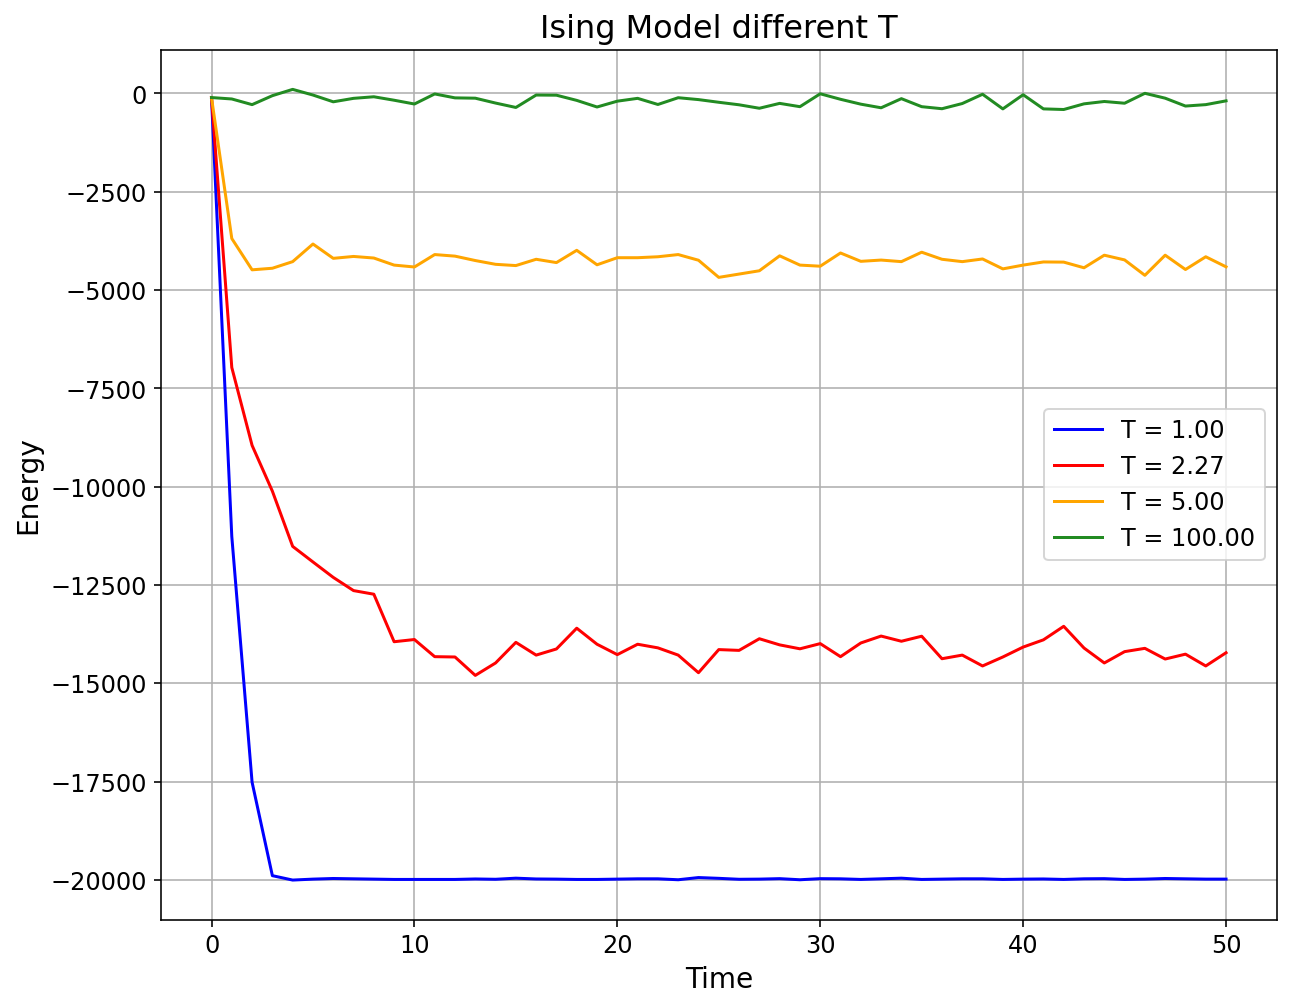

In [25]:
fig, axs = plt.subplots(1,1, figsize=(10, 8))  
color=['blue', 'red', 'orange', 'forestgreen']

for i in range(4):
    axs.plot(res[i], c=color[i], label="T = {:.2f}".format(Ts[i]))
    #axs.semilogx(res[i], c=color[i], label=("T=%f" %(Ts[i])))
axs.set_title("Ising Model different T")
axs.set_xlabel("Time")
axs.set_ylabel("Energy")
axs.legend()
axs.grid()

Dallo studio dell'energia in funzione del tempo della simulazione è possibile distinguere diversi tempi di equilibrio per le diverse temperature del sistema. Il sistema che impiega più tempo a termalizzarsi è il sistema alla temperatura critica $T_c$. Mi aspettavo questo fenomeno, perchè la temperatura critica è proprio la temperatura della transizione di fase (come si potrà osservare nelle prossime celle del notebook). Questo significa che il sistema, a cavallo tra stati in cui è magnetizzato e stati i cui non è magnetizzato fatica maggiormente a raggiungere l'equilibrio.

Alla temperatura critica il sistema impiega circa 20 steps dell'algoritmo `.SweepWolff()` per giungere l'equilibrio. Questo sarà il tempo di equilibrazione preso come riferimento. Pertanto nelle successive simulazioni prima di misurare le quantità di interesse farò compiere al sistema almeno questo numero di passi dell'algoritmo SweepWolff() per accertarmi di essere all'equilibrio.

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [26]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    if system_size == None :
        system_size = 100
    if temperature == None: 
        temperature = T_c
    if equilibration_time == 0:
        equilibration_time = 20
        
        
    ising = IsingModel(N=system_size, T=temperature)
    # equilibrate
    for i in range(equilibration_time):
        ising.SweepWolff(nTimes=1)
    # compute magnetization
    m=0
    for i in range(system_size):
        for j in range(system_size):
            m+=ising.lattice[i][j]
    m=m/(system_size)
    return m


### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [27]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=100)
#temperatures = np.array([1, T_c, 5, 100])
# system size
system_size = 64
# equilibration time
equilibration_time = 20

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in tqdm(temperatures):
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(magnetization)

100%|█████████████████████████████████████████| 100/100 [00:35<00:00,  2.84it/s]


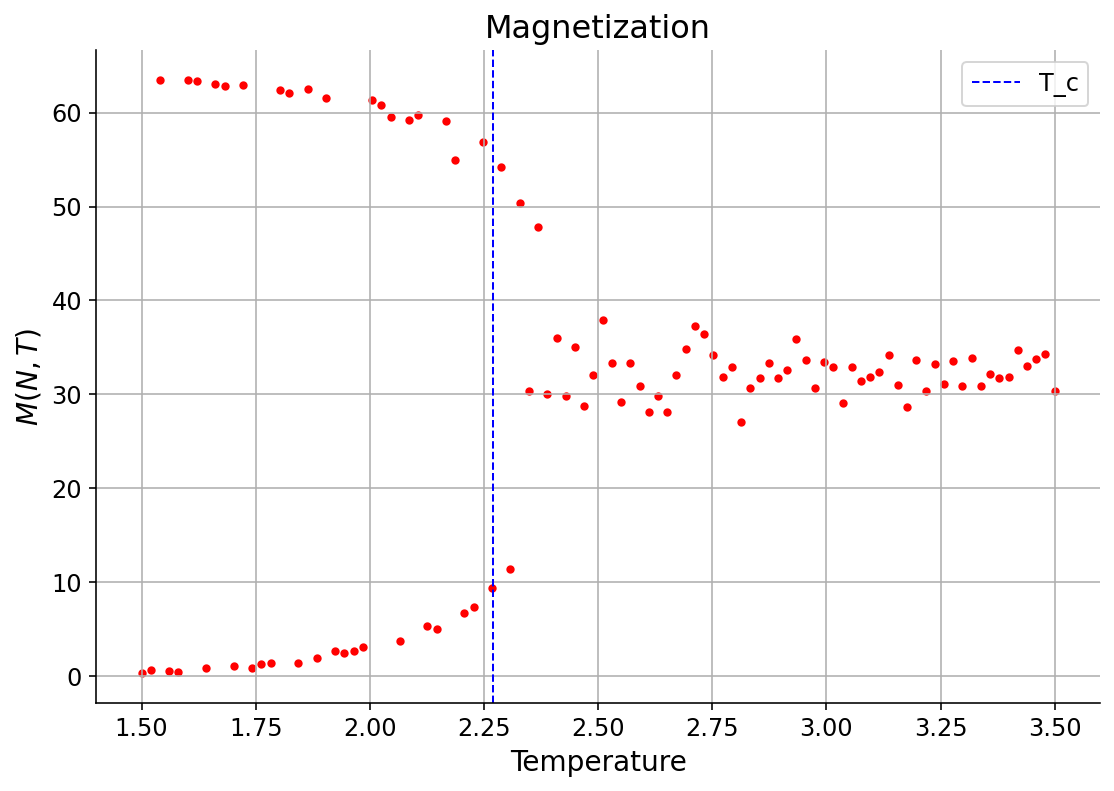

In [28]:
# define critical temperature
T_c = T_critical = 2.269185314213022

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.axvline(T_c,c="blue", lw=1, ls="dashed", label="T_c")
ax.scatter(
    temperatures, np.absolute(magnetizations),
    edgecolors="red", color="red", s=10
)
ax.set_title("Magnetization")
ax.set_xlabel("Temperature")
ax.set_ylabel(r"$M(N,T)$")
ax.grid()
ax.legend()

Ho effettivamente ottenuto l'andamento teorico della magnetizzazione in funzione della temperatura. Nel limite termodinamico $ \lim_{N\to 0}$ la magnetizzazione diventa una funzione a gradino con il salto esattamente alla temperatura critica $T_c$. A bassa temperatura ho due stati che in assenza di campo magnetico sono esattamente equivalenti: spin allineati in alto o spin allineati in basso. All'aumentare della temperatura la fluttuazione termica vince l'interazioni tra spin portando a configurazioni randomiche. In effetti oltre alla temperatura critica ho metà spin allineati in alto e metà spin allineati in basso come si può osservare dal grafico.


 <font color="red">N.B:</font> in questo caso la magnetizzazione deve appiattirsi attorno al valore $M(N,T)= 32$ per $64$ spin, e non attorno al valore zero. Questo perchè nell'algoritmo di Sethna gli spin possono valere $s=1$, $s=0$.


## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle = \frac{1}{T^2} \left\langle E^2 \right\rangle- \left\langle E \right\rangle^2 .
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

La suscettività magnetica del sistema risulta essere:

$$\chi(N,T) = \beta [ \langle M^2 \rangle  - \langle M \rangle^2]$$


Per mostrare questo comportamento della suscettività magnetica utilizzo l'approssimazione di campo medio. Generalmente l'hamiltoniana del sistema è data da $\mathcal{H}=-\sum_{\langle i j\rangle} J s_i s_j - H \sum_i s_i$. In campo medio, l'ipotesi è che la somma sui $j$ primi vicini (che indico con $\sum_j^*$) possa essere approssimata da un contributo medio $m$ che rappresenta proprio la magnetizzazione dell'intero sistema: $m=\frac{1}{N}\sum_j^Ns_j=\langle s \rangle$. Sto ipotizzando quindi che lo spin non interagisca differentemente con gli spin primi vicini, ma che interagisca con un contributo medio complessivo $m$.
In questo modo l'hamiltoniana del sistema diventa: $\mathcal{H}=-H\sum_is_i-J\sum_{\langle ij \rangle} s_is_j=-\sum_is_i[H+J\sum_j^*s_j]=-\sum_is_i[H+Jm]$. Questo è vero a meno di un fattore $\frac{1}{N}$ che per il momento trascuro.

Dal momento che la suscettività è data per definizione da $ \chi =\frac{\partial m}{\partial H}$, posso per facilità nei conti trascura il termine dell'esponente che non dipende dal campo magnetico $H$. Questa assunzione non fa perdere di generalità il problema dal momento che ho verificato che si ottiene lo stesso identico risultato anche mantenendo la dipendenza esplicita dal termine di accoppiamento $J$. Pertanto ho che:

$\chi=\frac{\partial m}{\partial H} = \frac{\partial}{\partial H} (\frac{\sum_s m_se^{\beta H \sum_i s_i}}{Z}) = \frac{\partial}{\partial H} (\frac{\sum_s m_se^{\beta H m_s}}{Z}) = \beta \sum_s \frac{m_s^2 e^{\beta H m_s}}{Z} + \sum_s m_s e^{\beta H m_s} \cdot \frac{\partial}{\partial H}(\frac{1}{Z}) = \beta \sum_s \frac{m_s^2 e^{\beta H m_s}}{Z} -\frac{\beta}{Z^2} (\sum_s m_se^{\beta Hm_s})^2 = \beta [ \langle M^2 \rangle  - \langle M \rangle^2]$


Avendo così ritrovato la formula riportata in alto.


### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [29]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    horizontal_edges = [
        (i%N, j%N, (i+1)%N, j%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i%N, j%N, i%N, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    
    
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1][j1]*config[i2][j2]
    return E / N**2

In [30]:
def compute_magnetization(config):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # compute magnetization
    m=0
    N=len(config)
    for i in range(N):
        for j in range(N):
            m+=config[i][j]
    m=m/(system_size)
    return m

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [31]:
def calculate_susceptibility_specific_heat(system_size, temperature, equilibration_time, n_samples):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    
    
    if system_size == None:
        system_size=50
    if temperature == None:
        temperature = T_c
    if equilibration_time == None:
        equilibration_time=20
    if n_samples == None:
        n_samples = 10
    
    # initiate model
    ising = IsingModel(N=system_size, T=temperature)
    # equilibrate
    for i in range(equilibration_time):
        ising.SweepWolff(nTimes=1)
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for _ in range(n_samples):
        # change from 0,1 to -1,1 notation
        config = ising.lattice*2-1
        # get magnetization
        m = compute_magnetization(config)
        ms.append(m)
        m2s.append(m**2)
        # get energy
        e=compute_energy(ising)
        es.append(e)
        e2s.append(e**2)
        # update system
        for r in range(10):
            ising.SweepWolff(nTimes=1)
            #ising.SweepMetropolis()
    
    # compute susceptibility and specific heat
    susceptibility = ((np.sum(m2s)/len(m2s)) -(np.sum(ms)*np.sum(ms))/(len(ms)*len(ms)))/temperature
    specific_heat = (np.sum(e2s)/len(e2s)-(np.sum(es)*np.sum(es))/(len(es)*len(es)))/(temperature*temperature)
    
    return susceptibility, specific_heat



### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [32]:
# define range of temperatures: 50 points from 1.5 to 4.

# system size
system_size = 50
# equilibration time
equilibration_time = 20
# n_samples
n_samples = 50
temperatures = np.linspace(1.5, 4, num=100)
sus=[]
heat=[]


# loop over temperatures, compute susceptibility and specific_heat
for temperature in tqdm(temperatures):
    res=calculate_susceptibility_specific_heat(system_size,temperature, 20,n_samples)
    sus.append(res[0])
    heat.append(res[1])


100%|█████████████████████████████████████████| 100/100 [09:21<00:00,  5.61s/it]


Text(0.5, 1.0, 'Heat Capacity - Ising Model N = 50')

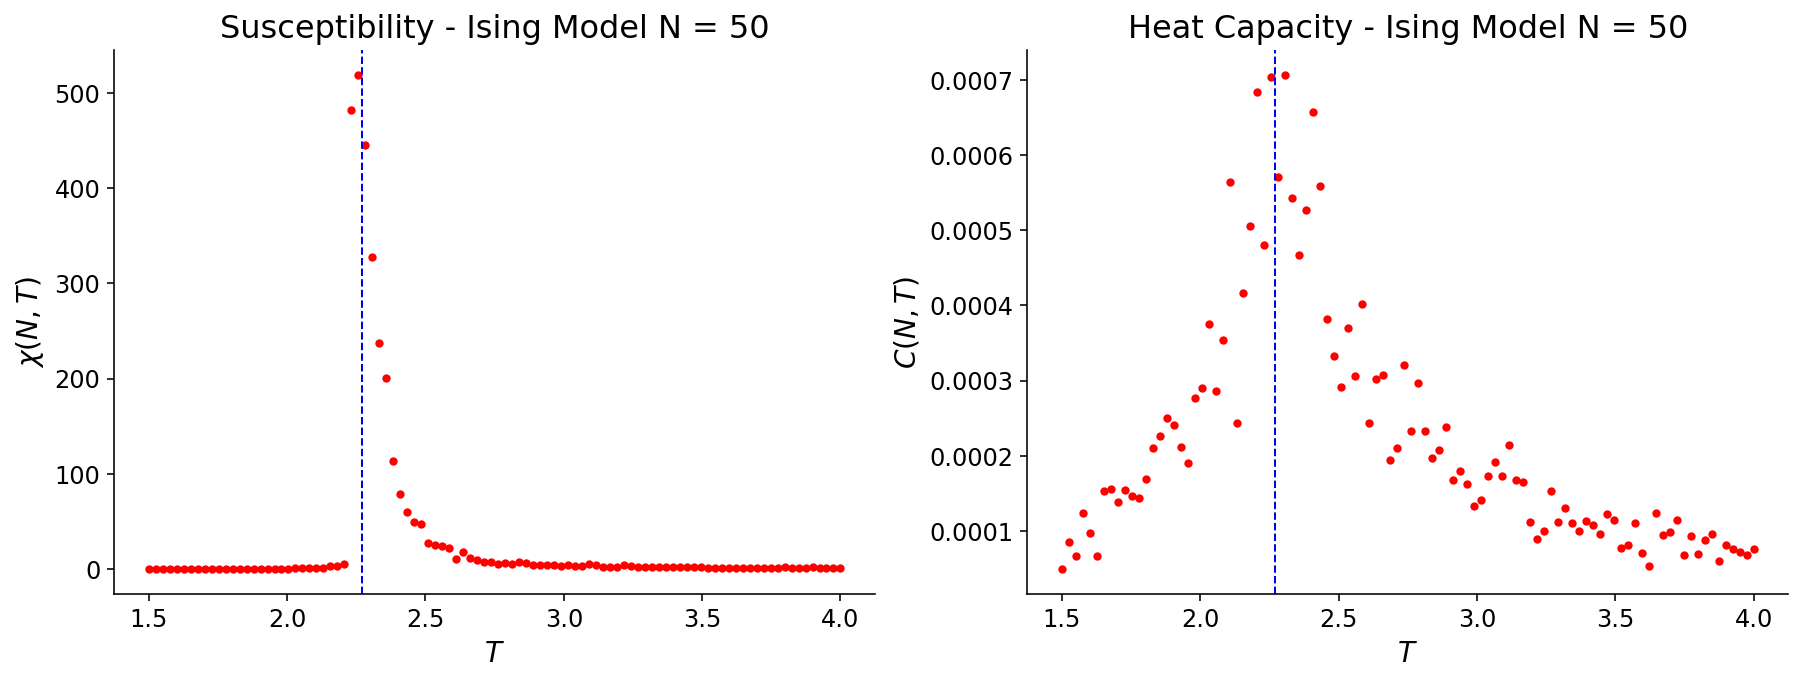

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax=ax1
ax.scatter(temperatures,sus,edgecolors="red", color="red", s=10)
ax.axvline(T_c, c="blue", lw=1, ls="dashed")
ax.set_ylabel(r"$\chi(N,T)$")
ax.set_xlabel(r"$T$")
ax.set_title("Susceptibility - Ising Model N = %i" %system_size )

ax=ax2
ax.scatter(temperatures,heat,edgecolors="red", color="red", s=10)
#ax.plot(temperatures,heat, color="red")
ax.axvline(T_c, c="blue", lw=1, ls="dashed")
ax.set_ylabel(r"$C(N,T)$")
ax.set_xlabel(r"$T$")
ax.set_title("Heat Capacity - Ising Model N = %i" %system_size)



### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

Secondo la definizione di transizione di fase dovuta a Fisher: un sistema presenta una transizione di fase qualora una delle derivate n-esime del potenziale termodinamico risulta essere discontinuo. Nel mio caso il potenziale termodinamica è l'energia libera di Heltotz. La suscettività e il calore specifico sono infatti derivate seconde dell'energia libera di Heltotz. Infatti:

1. $\chi(N,T) =\frac{\partial{m}}{\partial{H}}=-\frac{1}{N}\frac{\partial^2{F}}{\partial{H}^2}$
2. $C(N,T) = -T(\frac{\partial^2F}{\partial T^2})$

Entrambi i grafici mostrano un valore molto piccato attorno alla temperatura critica $T_c$: l'andamento ricorda un andamento Lorentziano. Pertanto nel limite termodinamico $ \lim_{N\to 0}$ queste funzioni tenderanno ad essere una Delta di Dirac $\delta$. Questo significa che gli intergali di queste due quantità $\chi(N,T)$ e $C(N,T)$ presenteranno una discontinuità a gradino alla temperatura critca $T_c$: l'integrale di una $\delta$ è la funzione a gradino di Heaviside $\theta$. Dal momento che gli integrali del calore specifico e della suscettività magnetica sono rispettivamente l'energia e la magnetizzazione del sistema (che sono a loro volta derivate prime dell'energia libera), significa che l'energia libera presenta una discontinuità nella derivata prima.

Questo si poteva effettivamente già capire dal grafico della magnetizzazione in funzione della temperatura.

In conclusione, questo sistema presenta una transizione di fase del primo ordine.

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

<img src="attachment:image.png" width="600">

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

La mia idea per l'assegnazione dei labels ai cluster è stata quella di utilizzare una funzione ricorsiva `write_neighbour_label` e una funzione `get_labels`. Nella funzione `get_labels`, incominciando dal primo spin, valuto se uno spin non presenta ancora nessun label. Qualora la risposta è affermativa assegno un label allo spin e richiamo la funzione `write_neighbour_label` su quel dato spin. Questa funzione valuto se questo spin presenta uno o più spin vicini con lo stesso valore. Se la risposta è affermativa allora assegna allo spin vicino lo stesso label dello spin di partenza e richiama la funzione la funzione `write_neighbour_label` stessa sullo spin vicino.

In questo modo, in maniera ricorsiva riesco correttamente a assegnare lo stesso label agli spin che appartengono alla stessa classe.

### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.


Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [34]:
def write_neighbour_label(config,i,j,labels):
            
            N=len(config)
            
            if (config[i%N][j%N] == config[(i+1)%N][j%N]) and (labels[(i+1)%N][j%N]==0):
                labels[(i+1)%N][j%N] = labels[i%N][j%N]
                write_neighbour_label(config,(i+1)%N,j%N,labels)

            if (config[i%N][j%N] == config[(i-1)%N][j%N]) and (labels[(i-1)%N][j%N]==0):
                labels[(i-1)%N][j%N] = labels[i%N][j%N]
                write_neighbour_label(config,(i-1)%N,j%N,labels)

            if (config[i%N][j%N] == config[i%N][(j+1)%N]) and (labels[i%N][(j+1)%N]==0):
                labels[i%N][(j+1)%N] = labels[i%N][j%N]
                write_neighbour_label(config,i%N,(j+1)%N,labels)

            if (config[i%N][j%N] == config[i%N][(j-1)%N]) and (labels[i%N][(j-1)%N]==0):
                labels[i%N][(j-1)%N] = labels[i%N][j%N]
                write_neighbour_label(config,i%N,(j-1)%N,labels)



    
    

def get_labels(config):
    """
    Get unique cluster labels.
    
    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
        
    N = len(config)
    labels = np.zeros((N,N))
    num=0

    for i in range(N):
        for j in range(N):
            if labels[i%N][j%N] ==0:
                num+=1
                labels[i%N][j%N]=num
                write_neighbour_label(config, i%N,j%N, labels)
            

    return labels

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [35]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [36]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1, -1, -1,  1],
                          [-1,  1, -1,  1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [37]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

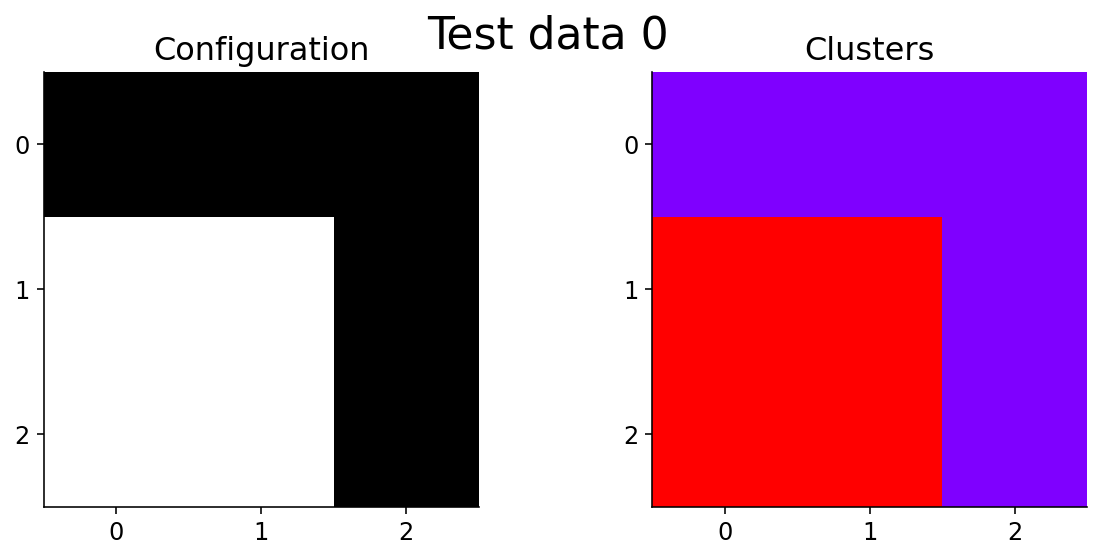

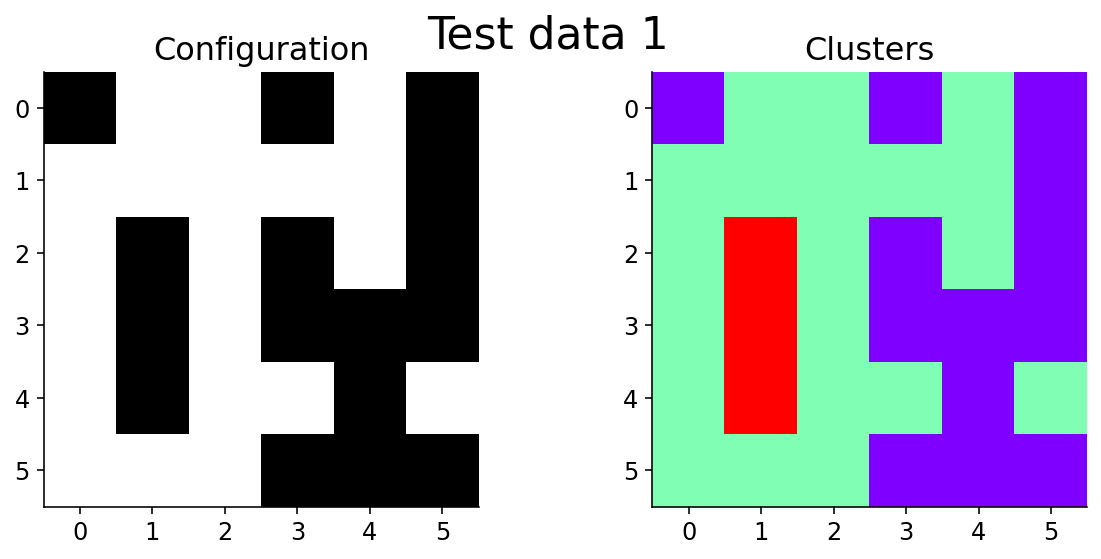

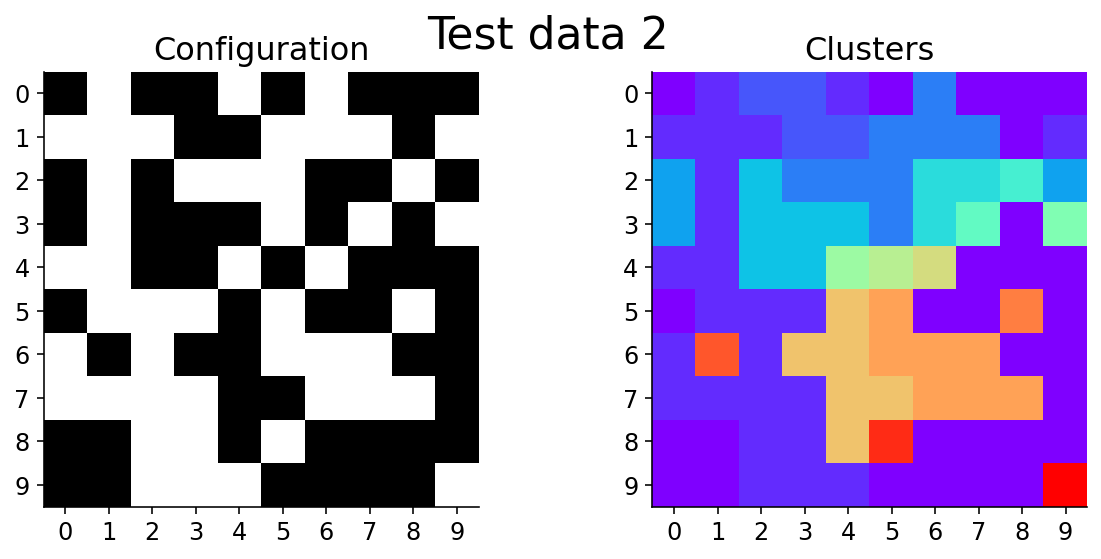

In [38]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

<AxesSubplot:>

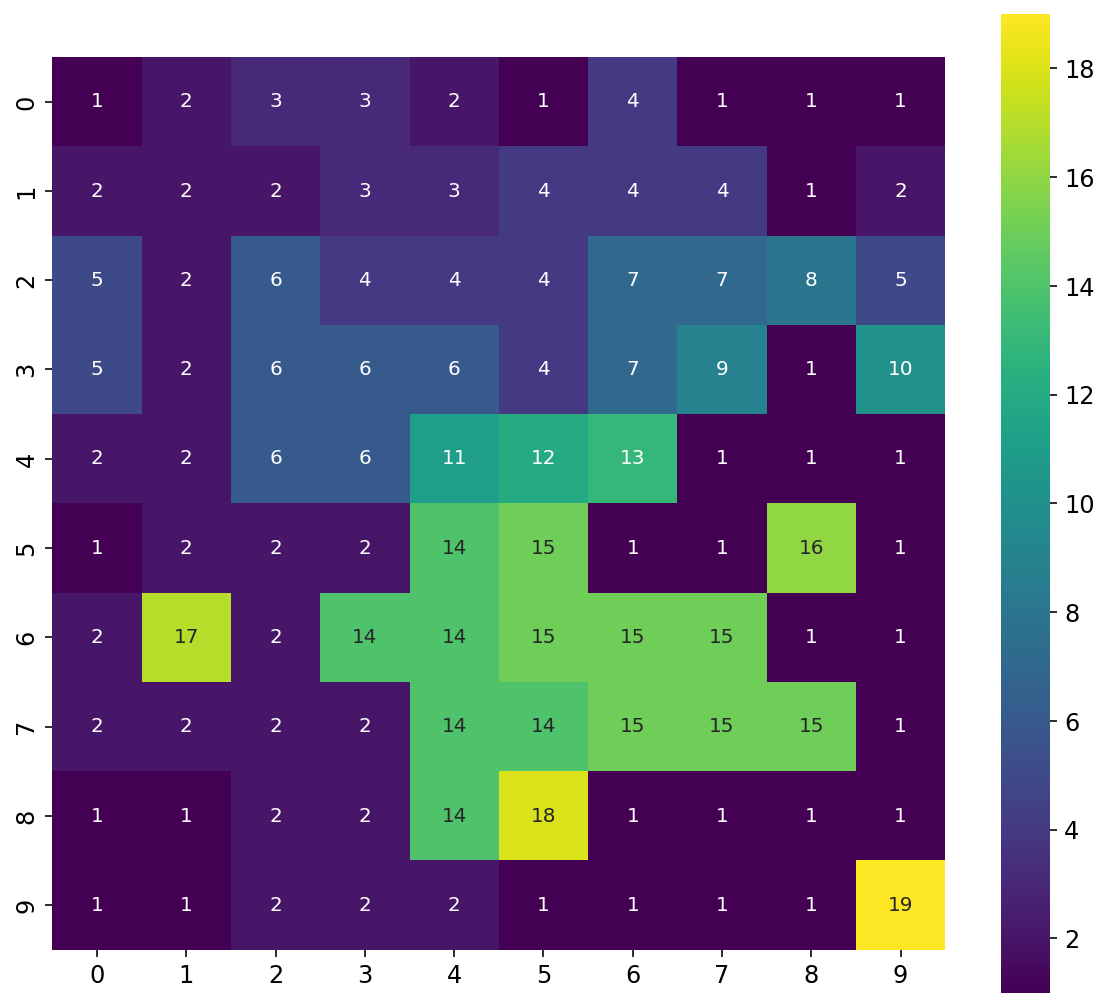

In [39]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [40]:
config = create_initial_config(N=500)
labels = get_labels(config)

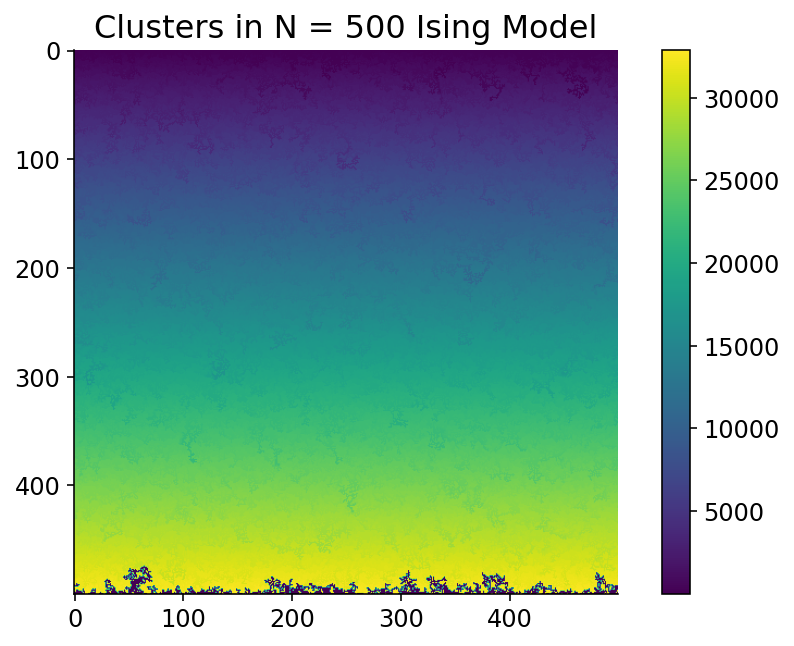

In [41]:
plt.figure(figsize=(8, 5))
plt.title("Clusters in N = 500 Ising Model")
plt.imshow(labels)
cbar=plt.colorbar()

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [42]:
from collections import Counter

In [43]:
def get_sizes(labels):
    flatted = labels.flatten()
    cnt = Counter()
    for label in flatted:
        cnt[label] +=1
    size=[]
    for i in range(1,len(cnt)+1):
        size.append(cnt[i])
    return size

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

Per alte temperature ho scarsa correlazione tra spin vicini dal momento che la fluttuazione termica vince sul termine energetico di accoppiamento degli spin. Questo significa Che mi aspetto tanti piccoli cluster per via della randomicità degli spin. Per cui mi aspetto che la distribuzione di probabilità sia molto piccata attorno alla dimensione $size=1$ e che tenda velocemente al valore zero.

### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

In [44]:
ising = IsingModel(N=100, T=100)
for r in tqdm(range(100)):
    ising.SweepWolff()
    #ising.SweepMetropolis()

config = ising.lattice*2-1
labels = get_labels(config)
sizes = get_sizes(labels)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.29it/s]


There are 1324 cluster in that configuration


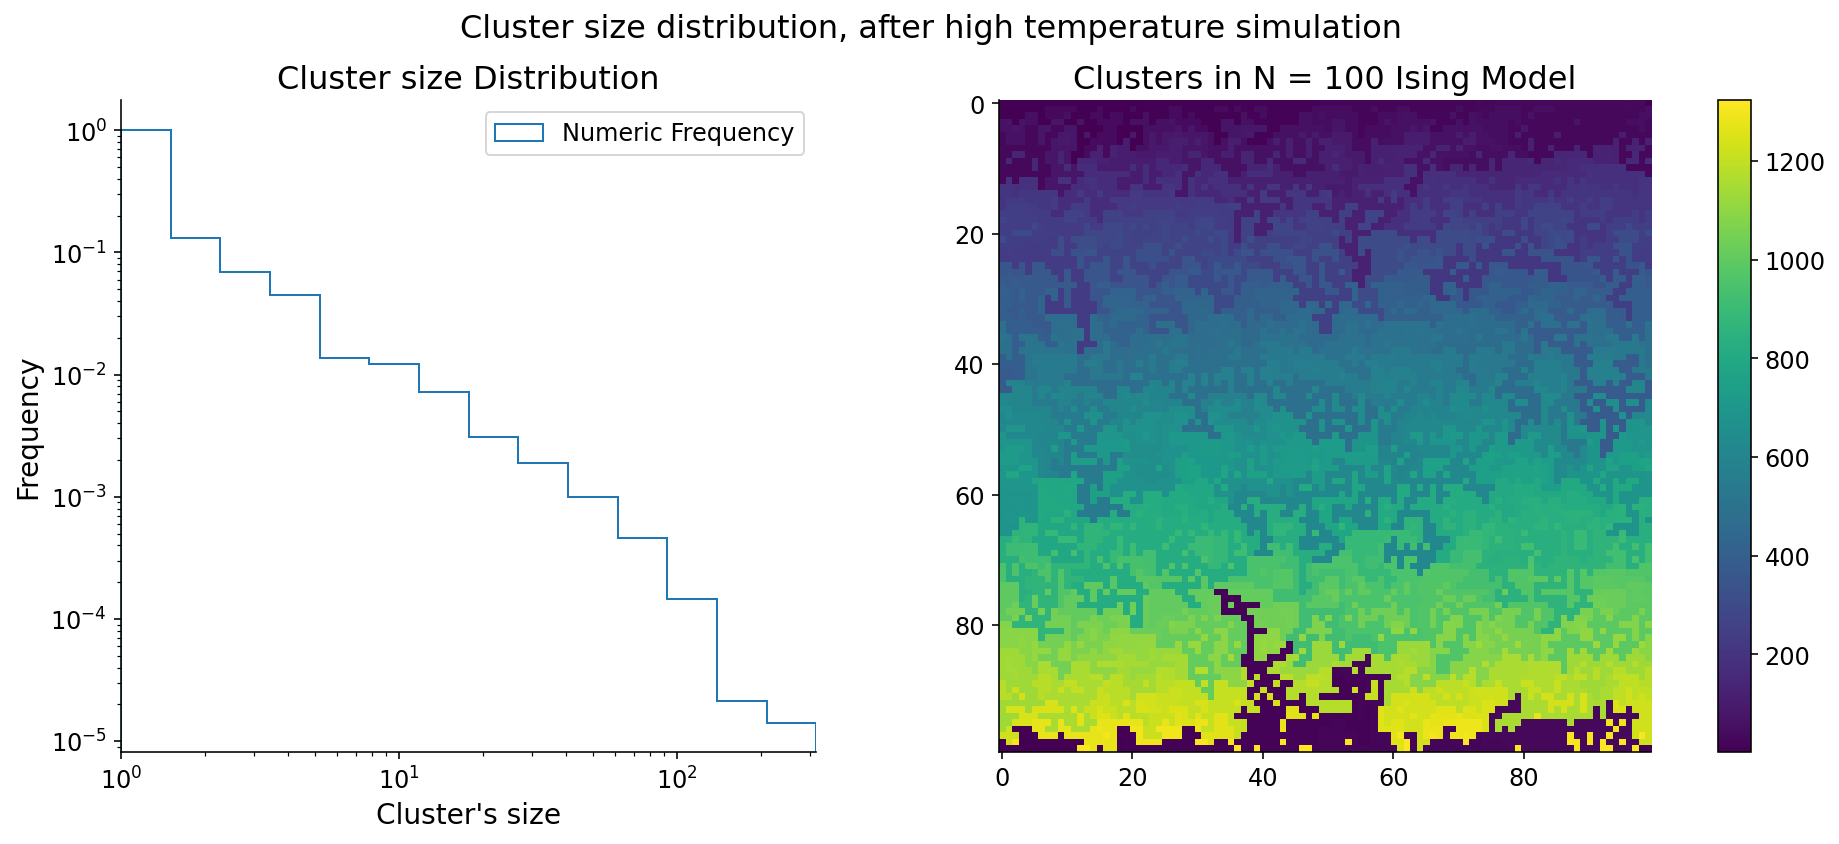

In [45]:

# use logarithmic bins and logarithmic axes!
bins = np.geomspace(min(sizes), max(sizes), num=15)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle('Cluster size distribution, after high temperature simulation', fontsize=16)


ax[0].hist(sizes, bins=bins, histtype="step", density=True, label="Numeric Frequency")
ax[0].set_title("Cluster size Distribution")
ax[0].set_xlabel("Cluster's size")
ax[0].set_ylabel("Frequency")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(min(sizes), max(sizes))
ax[0].legend()


ax[1].set_title("Clusters in N = 100 Ising Model")
#ax[1].imshow(labels)
img = ax[1].imshow(labels)
plt.colorbar(img, ax=ax,fraction=0.046, pad=0.04)
print("There are " +str(len(sizes)) + " cluster in that configuration")

I valori numerici ottenuti sono in accordo con la mia previsione.

### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

In [46]:

T_c = 2.269185314213022
# do simulation
ising = IsingModel(N=100, T=T_c)
for r in tqdm(range(100)):
    ising.SweepWolff()
    #ising.SweepMetropolis()

config = ising.lattice*2-1
labels2 = get_labels(config)
sizes2 = get_sizes(labels2)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 25.15it/s]


There are 355 cluster in that configuration


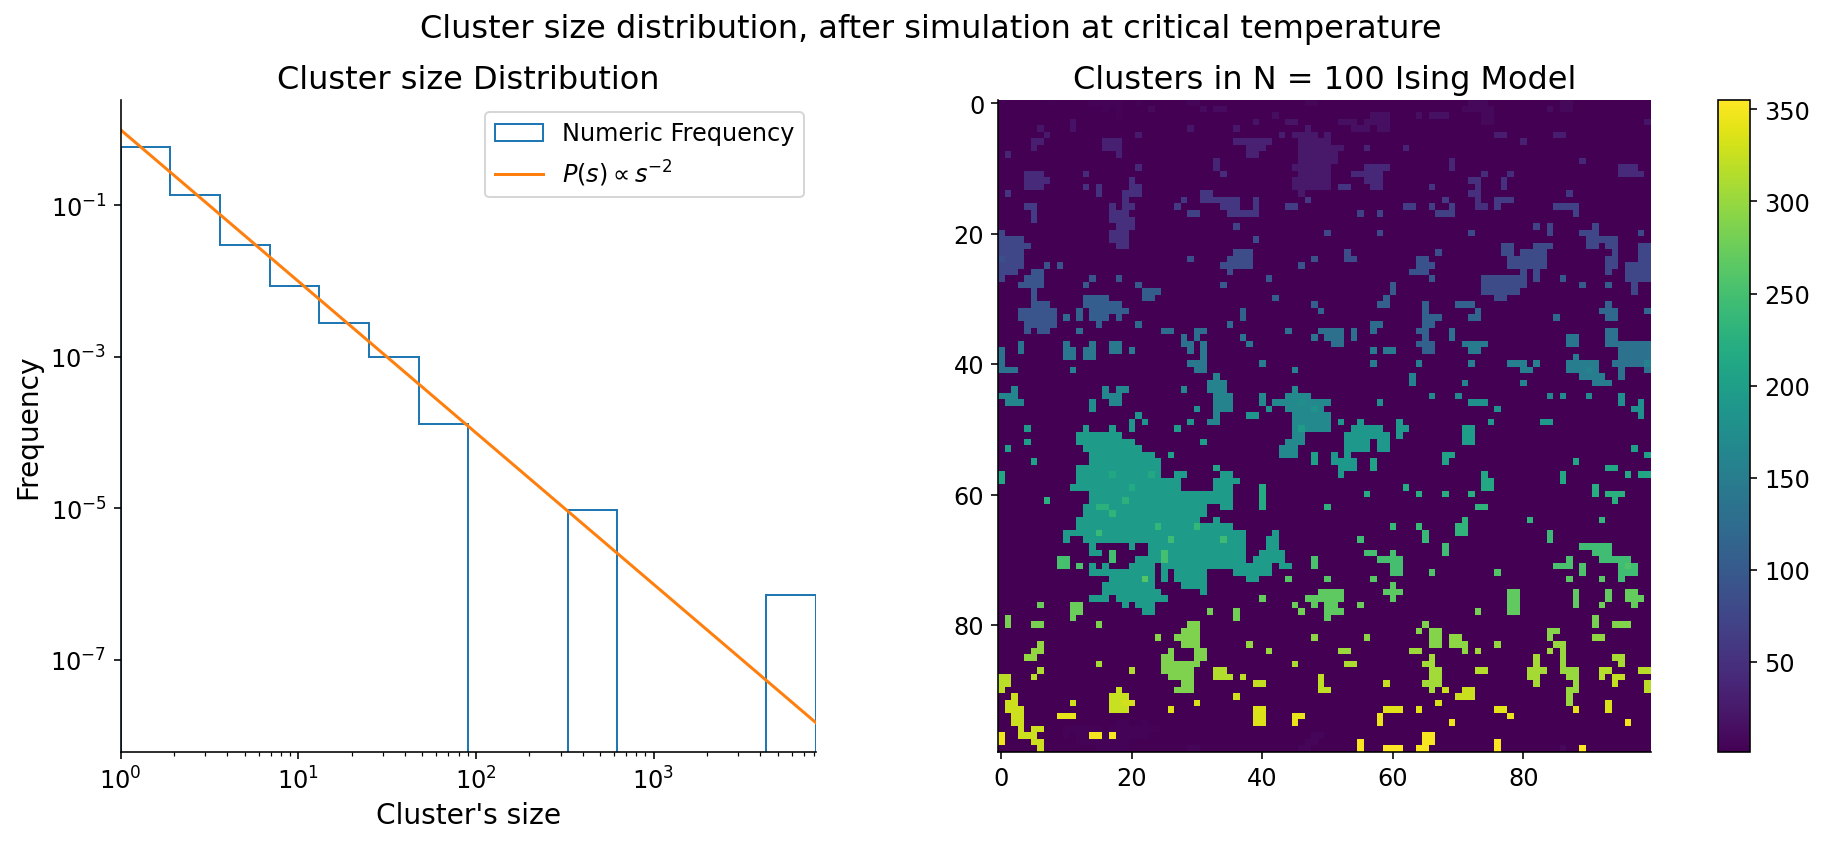

In [47]:
x=np.linspace(1,max(sizes2),num=10000)

y= x**(-2)   

bins2 = np.geomspace(min(sizes2), max(sizes2), num=15)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Cluster size distribution, after simulation at critical temperature', fontsize=16)

ax[0].hist(sizes2, bins=bins2, histtype="step",density=True, label="Numeric Frequency")
ax[0].plot(x,y,label=r"$P(s) \propto s^{-2}$")
ax[0].set_title("Cluster size Distribution")
ax[0].set_xlabel("Cluster's size")
ax[0].set_ylabel("Frequency")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(min(sizes2), max(sizes2))
ax[0].legend()

ax[1].set_title("Clusters in N = 100 Ising Model")
#ax[1].imshow(labels)
img = ax[1].imshow(labels2)
plt.colorbar(img, ax=ax,fraction=0.046, pad=0.04)


print("There are " +str(len(sizes2)) + " cluster in that configuration")

L'andamento dell'istogramma ottenuto è in perfetto accordo con la legge di potenza teorica $P(s) \propto s^{-2}$.

Inoltre è possibile osservare come la simulazione a temperatura più alta presenti un picco molto più netto al valore Cluster's size $=1$. Questo per il fatto che a quella temperatura ho molto meno correlazione di quando invece simulo il sistema alla temperatura critica $T_c$.